<a href="https://colab.research.google.com/github/YaninaK/anomaly-detection/blob/b1/notebooks/03_Sequence_anomalies_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обнаружение аномалий в начислениях за тепловую энергию


## 2. Аномалии 3.1.

### Примеры аномалий

Виды аномалий по показаниям приборов учёта тепловой энергии, которые необходимо выявлять (кроме объектов с видом энергопотребления ГВС (централ):

1. нулевые значения показаний за тепловую энергию в отопительный период (октябрь-апрель);

2. равные значения показаний в течение нескольких расчетных периодов;

3. снижение/рост показаний в отдельные месяцы по сравнению с показаниями за предыдущие периоды по данному объекту (с учётом фактической температуры наружного воздуха и количества отопительных дней в месяце);

4. аномально низкое/высокое (отклонение более 25%) потребление объекта в конкретном месяце по сравнению с аналогичными объектами (только для типов объекта «Многоквартирный дом») по критериям:
  - год постройки (по группам до 1958 г., 1959-1989 гг., 1990-2000 гг., 2001-2010 гг., 2011-2024 гг.),
  - этажность (по группам 1-2 этажа, 3-4 этажа, 5-9 этажей,10-12 этажей, 13 и более этажей),
  - площадь (±10%),
  - наличие ГВС ИТП (горячей воды, учитываемой тем же прибором).

In [1]:
initiate = False
if initiate:
  !git init -q
  !git clone -b b1  https://github.com/YaninaK/anomaly-detection.git -q

  from google.colab import drive
  drive.mount('/content/drive')

  !unzip -u -q /content/drive/MyDrive/ML_projects/08_anomaly_detection/data/01_raw/task#3.zip -d /content/anomaly-detection/data/01_raw
  !cp /content/drive/MyDrive/ML_projects/08_anomaly_detection/models/* /content/anomaly-detection/models/

%cd /content/anomaly-detection/

/content/anomaly-detection


In [2]:
import os
import sys

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), "data"))
sys.path.append(os.path.join(os.getcwd(), "models"))
sys.path.append(os.path.join(os.getcwd(), "src", "anomaly_detection"))

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from data.make_dataset import load_data
from models.serialize import load_model, load_model_history
from models.inference_ethalon_model import inference_data_preparation_pipeline
from models.inference_results import post_process_inference_results
from models.utilities import plot_loss, plot_metrics

from IPython.display import display

In [4]:
import warnings
warnings.filterwarnings('ignore')

## 1. Чтение данных

In [5]:
%%time
save = False
data, temperature, buildings = load_data(save=save)

CPU times: user 963 ms, sys: 54.2 ms, total: 1.02 s
Wall time: 1.11 s


## 2. Подготовка данных

In [6]:
%%time
ds_et_all, model_inputs_df = inference_data_preparation_pipeline(data, temperature, buildings)

CPU times: user 17.1 s, sys: 381 ms, total: 17.5 s
Wall time: 17.6 s


In [7]:
print(f"model_inputs_df.shape = {model_inputs_df.shape}\n")
model_inputs_df.sample(2)

model_inputs_df.shape = (45040, 16)



,object index,Адрес объекта 2,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Этажность объекта,Дата постройки,Общая площадь объекта,Группа этажность объекта,Улица,Дата постройки 2,Группа год постройки,Группа общая площадь объекта,seq index,LSTM input,last seq month
21017,2017,"г Уфа, ул. Кольцевая, д.36 корп.а",Многоквартирный дом,66589,1,4.0,1939-01-01,2834.1,3-4 этажа,ул. Кольцевая,1939-01-01,до 1958 г,3400,19,"[(3.894206896551724, 0.1006839969469158, 1), (...",2023-05-01
24042,2310,"г Уфа, ул. Ленина, д.150 корп.1",Многоквартирный дом,33263,1,6.0,2006-01-01,4018.6,5-9 этажей,ул. Ленина,2006-01-01,2001-2010 гг.,4300,19,"[(3.5665172413793105, 0.1006839969469158, 1), ...",2023-05-01


## 2. Загрузка модели

In [8]:
ethalon_model = load_model("ethalon_model_v1")
ethalon_model_training_history = load_model_history("ethalon_model_training_history_v1")

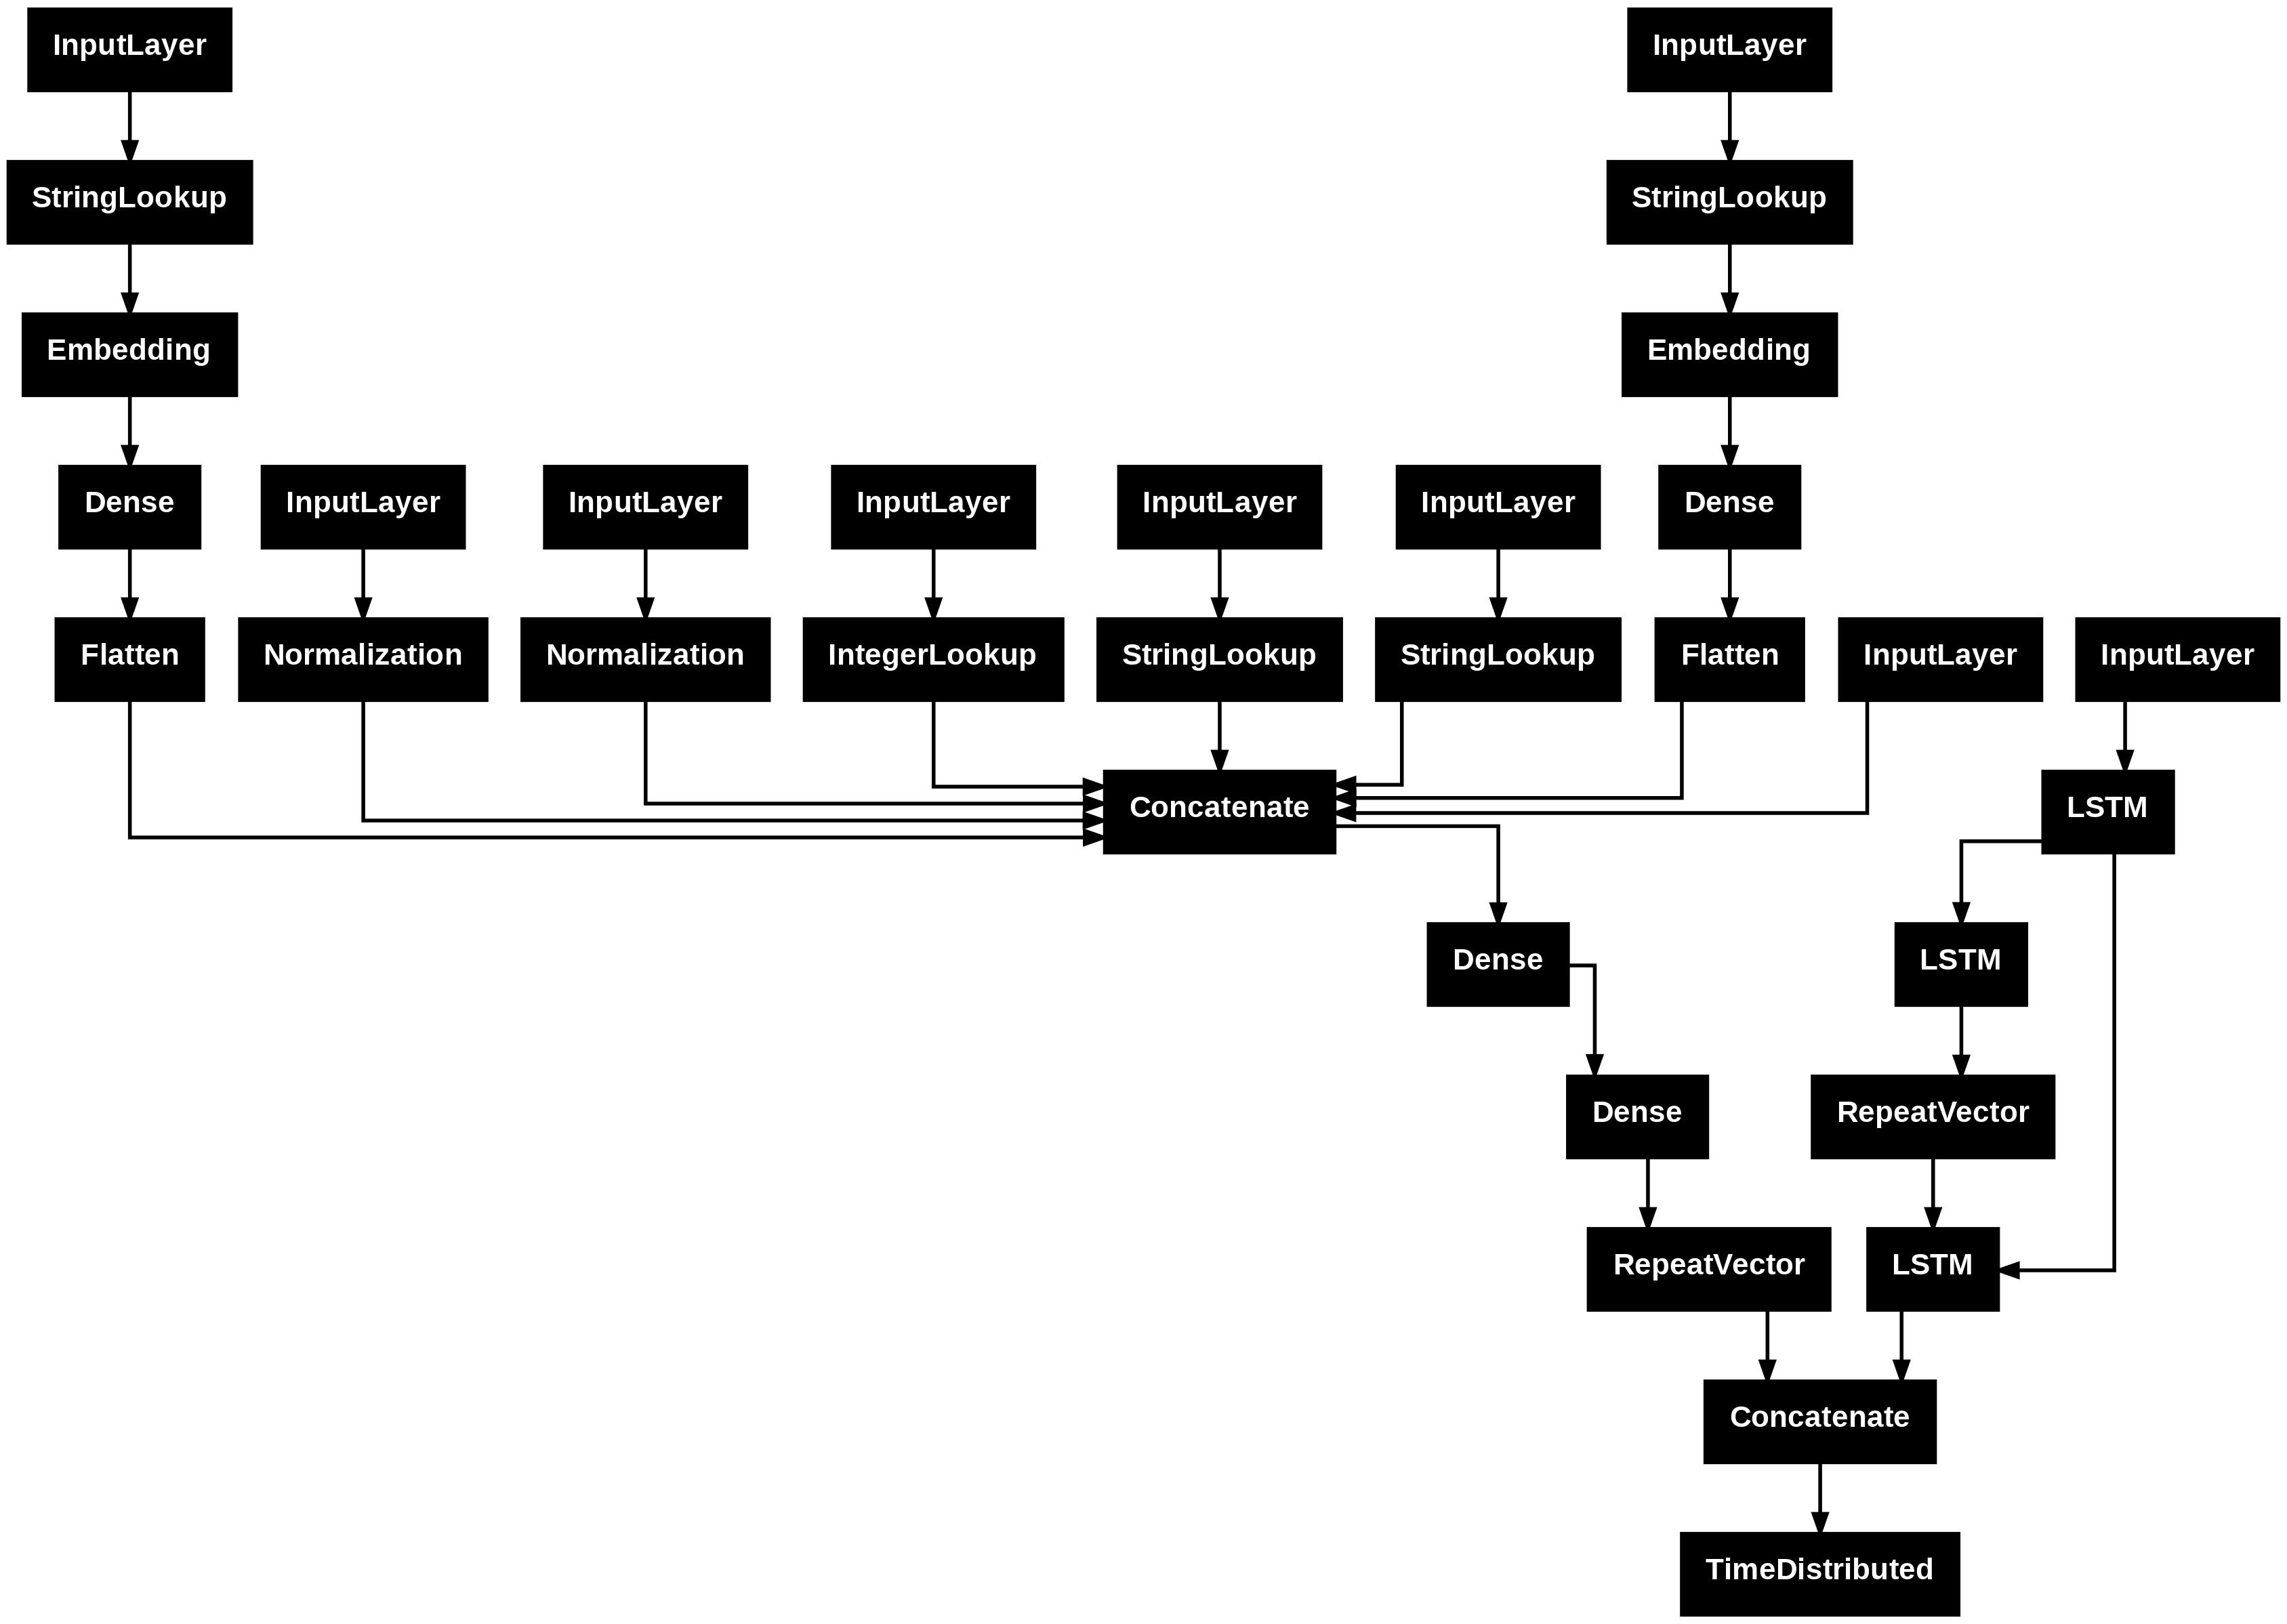

In [9]:
tf.keras.utils.plot_model(ethalon_model)

In [10]:
ethalon_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ object_type (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_prep          │ (None, 1)              │              0 │ object_type[0][0]      │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_prep               │ (None, 1)              │              0 │ street[0][0]           │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_emb           │ (None, 1, 5)           │             95 │ object_type_prep[0][0] │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_emb (Embedding)    │ (None, 1, 15)          │          3,135 │ street_prep[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ n_floors (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_dense (Dense) │ (None, 1, 2)           │             12 │ object_type_emb[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ floor_group (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ year_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_dense (Dense)      │ (None, 1, 8)           │            128 │ street_emb[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM input (InputLayer)   │ (None, 3, 3)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ n_floors_prep             │ (None, 1)              │              3 │ n_floors[0][0]         │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_prep (Normalization) │ (None, 1)              │              3 │ area[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group_prep           │ (None, 11)             │              0 │ area_group[0][0]       │
│ (IntegerLookup)           │                        │                │                        │
├──────────────────────

 Total params: 23,567 (92.07 KB)

 Trainable params: 7,853 (30.68 KB)

 Non-trainable params: 6 (32.00 B)

 Optimizer params: 15,708 (61.36 KB)

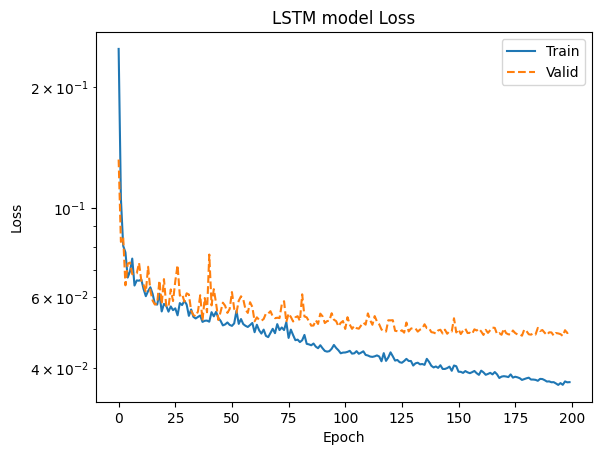

In [11]:
plot_loss(ethalon_model_training_history)

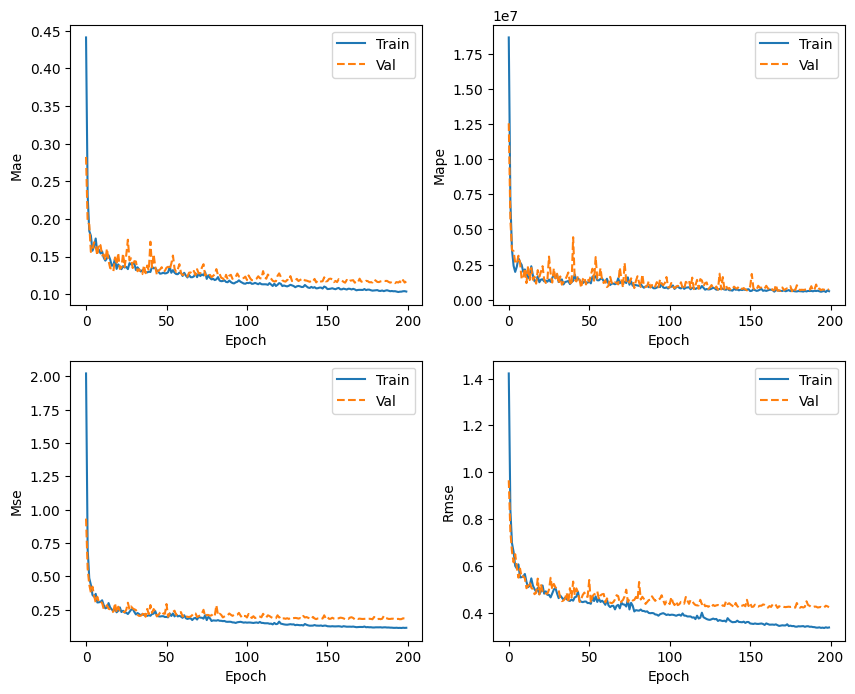

In [12]:
plot_metrics(ethalon_model_training_history)

## Инференс эталонной модели

In [13]:
%%time
BATCH_SIZE = 128
results_et_all = ethalon_model.predict(ds_et_all.batch(BATCH_SIZE))
results_et_all.shape

352/352 ━━━━━━━━━━━━━━━━━━━━ 68s 188ms/step
CPU times: user 1min 7s, sys: 1.84 s, total: 1min 9s
Wall time: 1min 8s


(45040, 1, 3)

In [14]:
%%time
result, model_inputs_df = post_process_inference_results(
     model_inputs_df, results_et_all, percentile=95
)

CPU times: user 23.2 s, sys: 1.02 s, total: 24.2 s
Wall time: 24.4 s


In [15]:
info = pd.DataFrame(
    model_inputs_df["Индекс соответствия прогнозу"]
).describe([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, .99])

display(info.style.format({0:"{:,.3f}"}))

,Индекс соответствия прогнозу
count,45040.000000
mean,1.382862
std,14.437296
min,0.000000
10%,0.013433
25%,0.035496
50%,0.100368
75%,0.299558
90%,1.064879
95%,3.750648


In [16]:
print(f"result.shape = {result.shape}")
result.sample(2)

result.shape = (2252, 12)


,Адрес объекта 2,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Этажность объекта,Дата постройки,Общая площадь объекта,Период потребления,Фактическое суточное потребление,Прогноз модели,Отклонение от прогноза,Индекс соответствия прогнозу
23207,"г Уфа, ул. Короленко, д.7 корп.а",Другое строение,354477,1,2.0,2013-01-01,0.01,2023-06-01,0.045700,-0.289172,0.334872,7.327606
35385,"г Уфа, ул. Рихарда Зорге, д.50",Другое строение,13006302,1,2.0,NaT,0.01,2023-05-01,0.084483,-0.514277,0.598760,7.087364
